In [23]:
#Load Dataset & Inspect Features and Labels
import pandas as pd
import numpy as np

df = pd.read_csv("breast-cancer.csv")
df.shape
df['diagnosis'].value_counts()

,count
diagnosis,
B,357
M,212


In [24]:
#Apply StandardScaler to normalize features
from sklearn.preprocessing import StandardScaler

df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})

X = df.drop(columns=['id', 'diagnosis'])
y = df['diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Shape of scaled data:", X_scaled.shape)
print("\nFirst 5 rows of scaled features:")
print(np.round(X_scaled[:5], 3))

print("\nMean of scaled features (should be ~0):")
print(np.round(X_scaled.mean(axis=0)[:5], 6))

print("\nStandard deviation of scaled features (should be ~1):")
print(np.round(X_scaled.std(axis=0)[:5], 6))


Shape of scaled data: (569, 30)

First 5 rows of scaled features:
[[ 1.097e+00 -2.073e+00  1.270e+00  9.840e-01  1.568e+00  3.284e+00
   2.653e+00  2.532e+00  2.218e+00  2.256e+00  2.490e+00 -5.650e-01
   2.833e+00  2.488e+00 -2.140e-01  1.317e+00  7.240e-01  6.610e-01
   1.149e+00  9.070e-01  1.887e+00 -1.359e+00  2.304e+00  2.001e+00
   1.308e+00  2.617e+00  2.110e+00  2.296e+00  2.751e+00  1.937e+00]
 [ 1.830e+00 -3.540e-01  1.686e+00  1.909e+00 -8.270e-01 -4.870e-01
  -2.400e-02  5.480e-01  1.000e-03 -8.690e-01  4.990e-01 -8.760e-01
   2.630e-01  7.420e-01 -6.050e-01 -6.930e-01 -4.410e-01  2.600e-01
  -8.050e-01 -9.900e-02  1.806e+00 -3.690e-01  1.535e+00  1.890e+00
  -3.760e-01 -4.300e-01 -1.470e-01  1.087e+00 -2.440e-01  2.810e-01]
 [ 1.580e+00  4.560e-01  1.567e+00  1.559e+00  9.420e-01  1.053e+00
   1.363e+00  2.037e+00  9.400e-01 -3.980e-01  1.229e+00 -7.800e-01
   8.510e-01  1.181e+00 -2.970e-01  8.150e-01  2.130e-01  1.425e+00
   2.370e-01  2.940e-01  1.512e+00 -2.400e-02  1

In [12]:
#Split data into train–test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)



X_train shape: (455, 30)
X_test shape : (114, 30)
y_train shape: (455,)
y_test shape : (114,)


In [13]:
#Train baseline SVM (Linear kernel)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

y_pred_linear = svm_linear.predict(X_test)
accuracy_score(y_test, y_pred_linear)


0.956140350877193

In [14]:
#Train SVM with RBF kernel & compare
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)
accuracy_score(y_test, y_pred_rbf)


0.9736842105263158

In [15]:
#Tune C and gamma using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale']
}

grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

grid.best_params_


{'C': 1, 'gamma': 'scale'}

In [17]:
#Confusion matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

confusion_matrix(y_test, y_pred_best)
print(classification_report(y_test, y_pred_best))



              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [18]:
#ROC curve & AUC score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_scores = best_model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

roc_auc


np.float64(0.99737962659679)

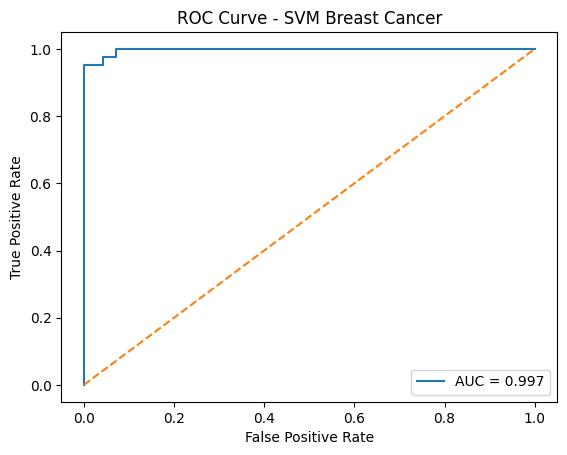

In [19]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM Breast Cancer")
plt.legend()
plt.show()


In [20]:
#Save tuned model pipeline (Scaler + SVM)
import joblib
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', best_model)
])

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, "svm_breast_cancer_pipeline.pkl")


['svm_breast_cancer_pipeline.pkl']